In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

import os
import pandas as pd
from torchvision.io import read_image

from torch.utils import data
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor


from torch.utils.data import DataLoader, TensorDataset, random_split


from torch.nn import Conv2d
from torch import optim

torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
sc = StandardScaler()


In [13]:


with open("Data/MoS2_Analysis_Processed_Data2", "rb") as fp:
    MoS2_data = pickle.load(fp)
    
df = pd.DataFrame(MoS2_data)
print(df.keys())

Index(['sampleLabel', 'sampleId', 'image', 'T', 'time', 'substrate'], dtype='object')


In [18]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedGroupKFold
from collections import Counter

with open("Data/MoS2_Analysis_Processed_Data2", "rb") as fp:   # Unpickling
  MoS2_data = pickle.load(fp)

df = pd.DataFrame(MoS2_data)
T = df['T']

T_classes = {900.0: 0, 950.0: 1, 1000.0: 2}
#print(MoS2_activities_substrate2['T'])
T_target = [T_classes[T[index]] for index, item in enumerate(T)]
sampleId = df['sampleId']
data_image = np.array([np.array(item) for item in df['image']])

#T_target = np.array(T_target).reshape(len(T_target),1)
print(len(T_target))

Data_CNN = data_image
print(Data_CNN.shape)
Data_CNN_rgb = np.repeat(Data_CNN[..., np.newaxis], 3, -1)
print(Data_CNN_rgb.shape)
Data_CNN_rgb = Data_CNN_rgb.transpose(0, 3, 1, 2)/255
print(Data_CNN_rgb.shape)




X = Data_CNN_rgb
Y = np.array(T_target)
groups = np.array(sampleId)

def stratified_train_test_group_kfold(X, Y, groups, n_splits, test_fold):

    group_kfold1 = StratifiedGroupKFold(n_splits=n_splits)

    print(type(group_kfold1.split(X, Y, groups)))
    Train_indices = []
    test_indices = []
    for (i, j) in group_kfold1.split(X, Y, groups):
        Train_indices.append(i)
        test_indices.append(j)

    Train_X = X[Train_indices[test_fold]]
    Train_Y = Y[Train_indices[test_fold]]
    Train_groups = groups[Train_indices[test_fold]]

    test_X = X[test_indices[test_fold]]
    test_Y = Y[test_indices[test_fold]]

    return Train_groups, Train_X, Train_Y, test_X, test_Y


262
(262, 224, 224)
(262, 224, 224, 3)
(262, 3, 224, 224)


In [19]:
train_val_groups, train_val_X, train_val_Y, test_X, test_Y = stratified_train_test_group_kfold(X, Y, groups, n_splits=10, test_fold=0)
print(train_val_X.shape)
print(Counter(train_val_Y))

<class 'generator'>
(235, 3, 224, 224)
Counter({1: 117, 2: 92, 0: 26})


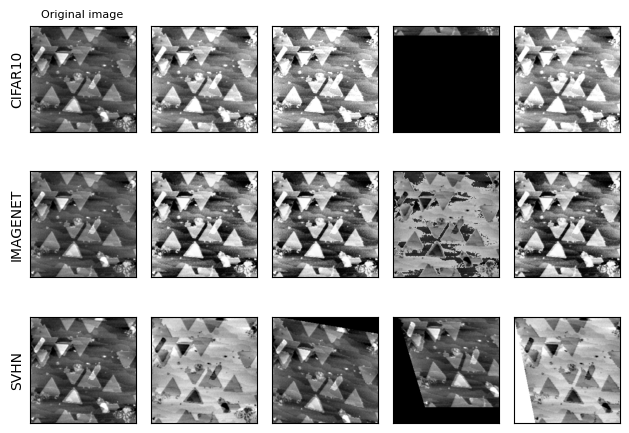

In [38]:
import torchvision.transforms as T

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


orig_img = torch.tensor(Data_CNN_rgb[2], dtype=torch.float32)
orig_img = T.ToPILImage()(orig_img)
policies = [T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET, T.AutoAugmentPolicy.SVHN]
augmenters = [T.AutoAugment(policy) for policy in policies]
imgs = [[augmenter(orig_img) for _ in range(4)] for augmenter in augmenters]
row_title = [str(policy).split('.')[-1] for policy in policies]
plot(imgs, row_title=row_title)

In [42]:
import torchvision.transforms as T
image_data = train_val_X
target = train_val_Y
def image_augmentation_temp_fn(image_data, target, sampleIds):
    num_images = 0
    data_augmented = []
    #print(image_data.shape)
    count_1000 = 0
    for index, orig_img in enumerate(image_data):
        
        if target[index] == 0:
            num_images = 9
        elif target[index] == 1:
            num_images = 2
        elif target[index] == 2:
            if count_1000 < 37:
                num_images = 2
                count_1000 += 1
            else:
                num_images = 3
        
 
        orig_img = torch.tensor(orig_img, dtype=torch.float32)
        orig_img = T.ToPILImage()(orig_img)
        policies = [T.AutoAugmentPolicy.IMAGENET]#[T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET, T.AutoAugmentPolicy.SVHN]
         
        for policy in policies:
            augmenter = T.AutoAugment(policy)
            for _ in range(num_images):
                this_augment = {}
                new_img = np.array(augmenter(orig_img))
                new_img = new_img.transpose(2, 0, 1)
                #print(new_img.shape)
                
                this_augment['sampleId'] = sampleIds[index]
                this_augment['T'] = target[index]
                this_augment['image'] = new_img
                
                data_augmented.append(this_augment)
    print(len(data_augmented))
    #df = pd.DataFrame(data_augmented)
    #images = df['image']
    #images = np.array([item for item in images])
    #print(type(images))
    #print(images.shape)            
    return data_augmented


In [43]:
data_augmented_temp = image_augmentation_temp_fn(train_val_X, train_val_Y, train_val_groups)

with open("Data/MoS2_Analysis_Augmented_Data", "wb") as fp:   #Pickling
  pickle.dump(data_augmented_temp, fp) 

707


In [41]:
print(len(train_val_groups))

235
